![alt text](https://images.ctfassets.net/22n7d68fswlw/aqZGiWDymcgIKgQk46ggs/294832f7df0760087069072fc1a312c6/imdb_top_250_movie_poster_by_saxon1964-d38rnod.jpg?w=1200)

## Classification de critiques de films

Nous allons créer un Feed-Dorward Deep Neural Network pour faire la classification d'une critique d'un film comme positive ou négative.  

Pour ce faire, R, Keras et un ensemble de données de IMDB qui contient des critiques et une variable qui représente la positivité de cette critique sont utilisés.


Pour commencer, l'importation des différentes libraries qui seront utilisés dans le programme pour faire le classificateur. 

- **keras**: Une abstraction de haut niveau de Tensorflow, une librairie développée par Google pour le deep learning en python. 
- **dplyr**: Librairie pour faire des manipulation de données, principalement utilisé pour la préparation des données ici.
- **ggplot2**: Permet de créé des graphique.
- **purrr**: Permet certain raccourcis de programmation fonctionnel.

In [7]:
# https://github.com/rstudio/keras/issues/147
library(keras)
library(dplyr)
library(ggplot2)
library(purrr)

### Téléchargement de l'ensemble de données
Nous téléchargons l'ensemble de données IMDB qui a déjà été prétraité pour etre représenté sous forme d'indice a la place de mots. Chaque index représente un mot. Les indeces des 10 000 mots les plus fréquents sont utilisés. Les données sont déjà séparer en *train/test* avec 2 500 entrés chancun.

In [8]:
vocab_size <- 10000

imdb <- dataset_imdb(num_words = vocab_size)
c(train_data, train_labels) %<-% imdb$train
c(test_data, test_labels) %<-% imdb$test

`1 14 22 16 43 530 973 1622 1385 65 458 4468 66 3941 4 173 36 256 5 25 100 43 838 112 50 670 2 9 35 480 284 5 150 4 172 112 167 2 336 385 39 4 172 4536 1111 17 546 38 13 447 4 192 50 16 6 147 2025 19 14 22 4 1920 4613 469 4 22 71 87 12 16 43 530 38 76 15 13 1247 4 22 17 515 17 12 16 626 18 2 5 62 386 12 8 316 8 106 5 4 2223 5244 16 480 66 3785 33 4 130 12 16 38 619 5 25 124 51 36 135 48 25 1415 33 6 22 12 215 28 77 52 5 14 407 16 82 2 8 4 107 117 5952 15 256 4 2 7 3766 5 723 36 71 43 530 476 26 400 317 46 7 4 2 1029 13 104 88 4 381 15 297 98 32 2071 56 26 141 6 194 7486 18 4 226 22 21 134 476 26 480 5 144 30 5535 18 51 36 28 224 92 25 104 4 226 65 16 38 1334 88 12 16 283 5 16 4472 113 103 32 15 16 5345 19 178 32`

### Affichage du texte
Il est possible de remplacer les indexes par la valeur textuel qui leurs correspondes pour visualiser le texte original de la critique.

In [9]:
word_index <- dataset_imdb_word_index()

word_index_df <- data.frame(
  word = names(word_index),
  idx = unlist(word_index, use.names = FALSE),
  stringsAsFactors = FALSE
)

# The first indices are reserved  
word_index_df <- word_index_df %>% mutate(idx = idx + 3)
word_index_df <- word_index_df %>%
  add_row(word = "<PAD>", idx = 0)%>%
  add_row(word = "<START>", idx = 1)%>%
  add_row(word = "<UNK>", idx = 2)%>%
  add_row(word = "<UNUSED>", idx = 3)

word_index_df <- word_index_df %>% arrange(idx)

decode_review <- function(text){
  paste(map(text, function(number) word_index_df %>%
              filter(idx == number) %>%
              select(word) %>% 
              pull()),
        collapse = " ")
}

decode_review(train_data[[1]])

[1] "<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

### Longueur des *inputs*
Les inputs d'un *neural network* doivent être de la même grandeur. En ce moment, les critiques ont des longueurs différentes. Nous allons donc mettre une longueur maximum (256) et couper les *inputs* trop grand et remplire les critiques trop courte avec des 0, qui représente un *padding*.

In [10]:
train_data <- pad_sequences(
  train_data,
  value = word_index_df %>% filter(word == "<PAD>") %>% select(idx) %>% pull(),
  padding = "post",
  maxlen = 256
)

test_data <- pad_sequences(
  test_data,
  value = word_index_df %>% filter(word == "<PAD>") %>% select(idx) %>% pull(),
  padding = "post",
  maxlen = 256
)

Longueurs:
- Avant
 - `train_data[1, ]` = 218
 - `train_data[2, ]` = 189
- Après
 - `train_data[1, ]` = 256
 - `train_data[2, ]` = 256

Example `train_data[1, ]` avec le *padding*:  
`1 14 22 16 43 530 973 1622 1385 65 458 4468 66 3941 4 173 36 256 5 25 100 43 838 112 50 670 2 9 35 480 284 5 150 4 172 112 167 2 336 385 39 4 172 4536 1111 17 546 38 13 447 4 192 50 16 6 147 2025 19 14 22 4 1920 4613 469 4 22 71 87 12 16 43 530 38 76 15 13 1247 4 22 17 515 17 12 16 626 18 2 5 62 386 12 8 316 8 106 5 4 2223 5244 16 480 66 3785 33 4 130 12 16 38 619 5 25 124 51 36 135 48 25 1415 33 6 22 12 215 28 77 52 5 14 407 16 82 2 8 4 107 117 5952 15 256 4 2 7 3766 5 723 36 71 43 530 476 26 400 317 46 7 4 2 1029 13 104 88 4 381 15 297 98 32 2071 56 26 141 6 194 7486 18 4 226 22 21 134 476 26 480 5 144 30 5535 18 51 36 28 224 92 25 104 4 226 65 16 38 1334 88 12 16 283 5 16 4472 113 103 32 15 16 5345 19 178 32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0`

### Données de validation
Lors de l'entrainement du *neural network*, le *accuracy* du modèle va être calculer avec des données différente de celle du *training set*. Ce set de données s'appel *validation set*. Nous prenons donc 20% des données pour la validation et le reste pour l'entrainement.

In [11]:
split_index <- round(nrow(train_data) * 0.2)

x_val <- train_data[1:split_index, ]
y_val <- train_labels[1:split_index]

split_index <- split_index + 1

partial_x_train <- train_data[split_index:nrow(train_data), ]
partial_y_train <- train_labels[split_index:length(train_labels)]

### Architecture du réseau
![](https://miro.medium.com/max/978/0*0mia7BQKjUAuXeqZ.jpeg)

#### Fonctions d'activation

ReLU:
- Plus facile a calculer que sigmoid.
- En pratique, il y a une meilleur performence avec Relu plutôt que sigmoid. (Krizhevsky et al.)

Sigmoid:
- Permet un pourcentage pour la probabilité de la sortie
- Est toujours entre 0 <= x <= 1

![](https://cdn-images-1.medium.com/max/1600/1*XxxiA0jJvPrHEJHD4z893g.png)

In [18]:

model <- keras_model_sequential() %>% 
    layer_embedding(input_dim = vocab_size, output_dim = 16) %>%
    layer_global_average_pooling_1d() %>%
    layer_dense(units = 16, activation = "relu") %>% 
    layer_dense(units = 16, activation = "relu") %>% 
    layer_dense(units = 1, activation = "sigmoid")

model %>% summary()

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
embedding_4 (Embedding)             (None, None, 16)                160000      
________________________________________________________________________________
global_average_pooling1d_4 (GlobalA (None, 16)                      0           
________________________________________________________________________________
dense_10 (Dense)                    (None, 16)                      272         
________________________________________________________________________________
dense_11 (Dense)                    (None, 16)                      272         
________________________________________________________________________________
dense_12 (Dense)                    (None, 1)                       17          
Total params: 160,561
Trainable params: 160,561
Non-trainable params: 0
_____________________________________

![](https://cdn-images-1.medium.com/max/1200/1*HLMqJxNTfmIotV7M7wyy5A.gif)

In [13]:
my.optimizer <- 'adam'

![](https://cdn-images-1.medium.com/max/1200/1*PK0iVgkQepmVCprtTgbsGg.png)

In [14]:
my.loss <- 'binary_crossentropy'

### Compilation du réseau, entrainement et évaluation

$loss
[1] 0.9236185

$acc
[1] 0.84276

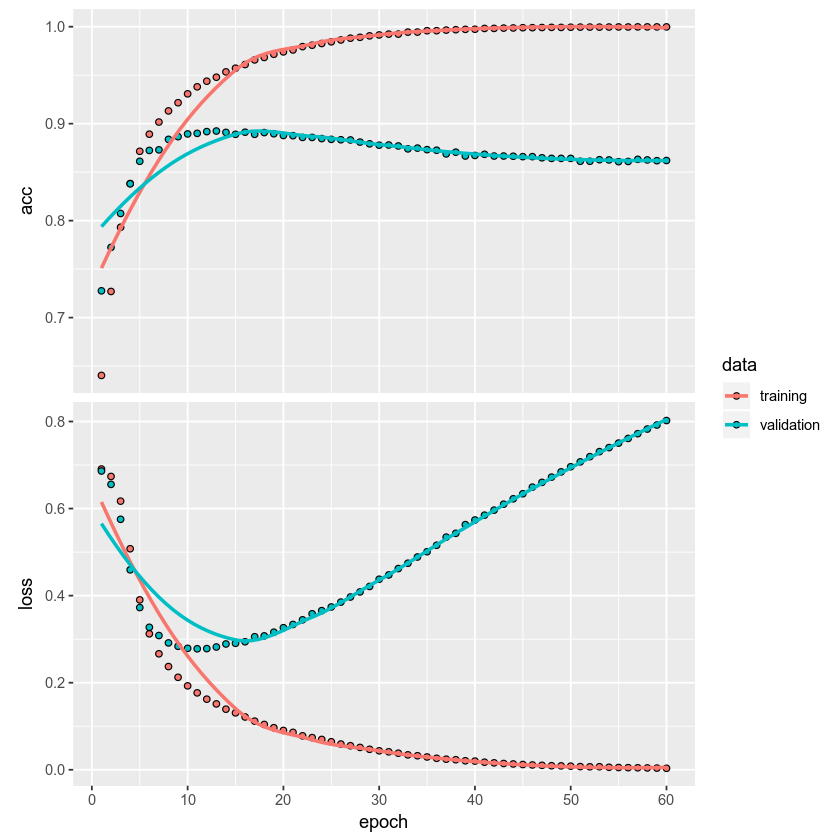

In [19]:
model %>% compile(
  optimizer = my.optimizer,
  loss = my.loss,
  metrics = list('accuracy')
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 60,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)

plot(history)
model %>% evaluate(test_data, test_labels)

### Arrêter l'entrainement pour éviter le *overfit*

$loss
[1] 0.2944331

$acc
[1] 0.87932

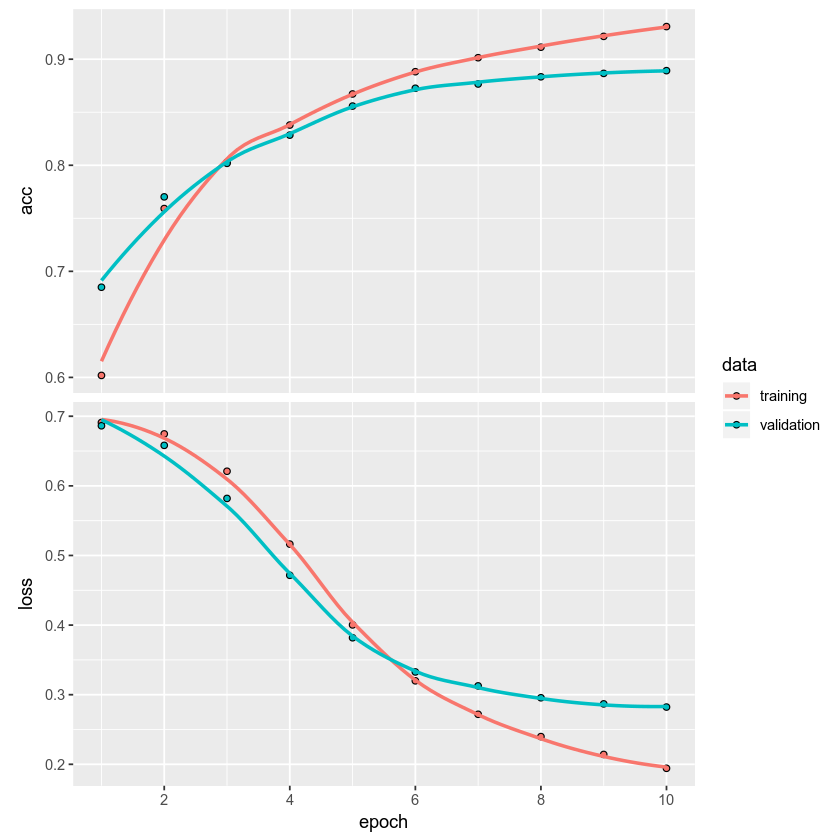

In [17]:
model <- keras_model_sequential() %>% 
    layer_embedding(input_dim = vocab_size, output_dim = 16) %>%
    layer_global_average_pooling_1d() %>%
    layer_dense(units = 16, activation = "relu") %>% 
    layer_dense(units = 16, activation = "relu") %>% 
    layer_dense(units = 1, activation = "sigmoid")

model %>% compile(
  optimizer = my.optimizer,
  loss = my.loss,
  metrics = list('accuracy')
)

history <- model %>% fit(
  partial_x_train,
  partial_y_train,
  epochs = 10,
  batch_size = 512,
  validation_data = list(x_val, y_val)
)

plot(history)
model %>% evaluate(test_data, test_labels)

### Faire une prédiction

In [20]:
predictions <- model %>% predict(test_data)

decode_review(test_data[1,])

[1] "<START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite <UNK> so all you madison fans give this a miss <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>"

In [27]:
test_labels[1]

[1] 0

In [28]:
predictions[1,]

[1] 0.006340472